# **Data analysis**

# **Environment Setup**

In [28]:
import numpy as np
import random as rm
import seaborn as sns
from tqdm import trange
import time
import sq_fast

from numba import njit

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import math
import pandas as pd
from pathlib import Path

import os
from scipy.spatial import cKDTree
from scipy.signal import find_peaks
import plotly.express as px
import numpy as np

import kaleido

In [39]:
plt.style.use('science.mplstyle')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "STIXGeneral"
})

plt.rcParams.update({'font.size': 12, 'legend.fontsize': 10,})


In [30]:
# plt.rcParams['figure.figsize'] = (6, 4)
# plt.rcParams['figure.dpi'] = 100
# sns.set_style("ticks")
# sns.set_theme(
#     style="white",
#     context="notebook",
#     font_scale=1.2,
#     rc={
#         "font.family": "serif",
#         "font.serif": ["Times New Roman", "DejaVu Serif"],
#         "font.size": 16,
#         "axes.labelsize": 16,
#         "axes.titlesize": 16,
#         "xtick.labelsize": 16,
#         "ytick.labelsize": 16,
#         "legend.fontsize": 16,
#         "mathtext.fontset": "cm",
#         "xtick.bottom": True,
#         "ytick.left": True,
#         "axes.titleweight": "bold",
#         "legend.frameon": False,
#         "legend.framealpha": 1,
#         "legend.facecolor": "white",
#         "legend.edgecolor": "black",
#         "lines.linewidth": 1.75,
#         "axes.linewidth": 1.2,
#         "grid.linewidth": 0.6,
#         "grid.alpha": 0.8,
#         "grid.linestyle": "--",
#         "lines.markersize": 5,
#     }
# )
# sns.set_palette("bright")
# plt.rcParams.update({
#     "xtick.direction": "in",
#     "ytick.direction": "in",
#     "xtick.top": True,
#     "ytick.right": True,
#     "xtick.minor.visible": True,
#     "ytick.minor.visible": True,
# })

## Analysis

In [31]:
from pathlib import Path

simulation_path = Path("./output/n216_density1.00_t1.0-0.0001-0.98/")

def get_simulation_parameters(filepath):
    params = {}
    keys = [
        #"melting", "path", 
        #"N", "freeze_mc_steps", "alpha", "C0", "density",
        "N", "freeze_mc_steps", "alpha", "density",
        "charge", "initial_temp", "final_temp", "temp_step"
    ]
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if i < len(keys):
                value = line.split('!')[0].strip()
                # Handle types properly
                if keys[i] == "melting" or keys[i] == "N":
                    params[keys[i]] = int(value)
                elif keys[i] == "path":
                    # Remove quotes if present
                    params[keys[i]] = value.strip('"').strip("'")
                else:
                    params[keys[i]] = float(value)
    params['L'] = (params['N'] / params['density']) ** (1/3)
    return params

input_parameters_file = simulation_path / "input_parameters.in"

parameters = get_simulation_parameters(input_parameters_file)
print(parameters)


{'N': 216, 'freeze_mc_steps': 0.5, 'alpha': 0.7, 'density': 1.0, 'charge': 1.0, 'initial_temp': 1.0, 'final_temp': 0.0001, 'temp_step': 0.98, 'L': 5.999999999999999}


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_63322/31057736.py:4: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(energy_evolution_file, sep='\s+', header=None, names=['mc_step', 'energy', 'temperature', ])


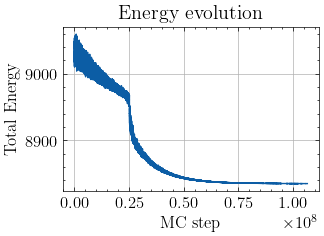

In [32]:

def get_simulation_energy_evolution(simulation_path):
    energy_evolution_file = simulation_path / "energy.out"

    df = pd.read_csv(energy_evolution_file, sep='\s+', header=None, names=['mc_step', 'energy', 'temperature', ])
    reset_indices = df['mc_step'].diff() < 0
    offsets = np.where(reset_indices, df['mc_step'].shift(1), 0)
    cumulative_offset = offsets.cumsum()
    df['total_mc_step'] = df['mc_step'] + cumulative_offset

    plt.figure()
    plt.plot(df['total_mc_step'], df['energy'], label='Energía del sistema')
    plt.xlabel('MC step')
    plt.ylabel('Total Energy')
    plt.title('Energy evolution')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(simulation_path / "energy_vs_mc_steps.pdf")
    plt.show()
    
get_simulation_energy_evolution(simulation_path)

In [33]:
def gamma(rho, T):
    a = (3/(4*np.pi*rho))**(1/3)
    return 1/(a*T)

<>:5: SyntaxWarning:

invalid escape sequence '\s'

<>:5: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_63322/965184475.py:5: SyntaxWarning:

invalid escape sequence '\s'



{'Tc': [np.float64(0.1128278142264741)], 'gamma': [np.float64(14.287185877595675)], 'cv_max_norm': [np.float64(25.770046952495868)], 'density': [1.0], 'simulation': [PosixPath('output/n216_density1.00_t1.0-0.0001-0.98')]}
Results saved in: output/n216_density1.00_t1.0-0.0001-0.98/simulation_results.csv


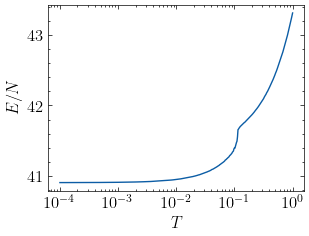

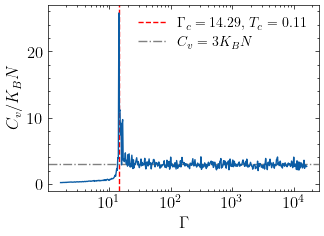

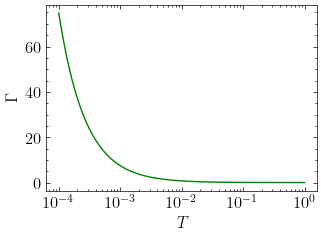

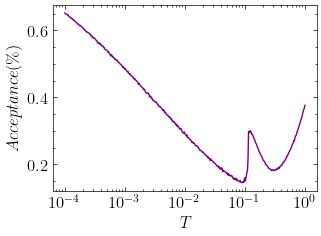

In [40]:
def get_energy_cv_gamma_evolution_vs_temperature(simulation_path, parameters):
    energy_evolution_file = simulation_path / "heat_capacity.out"
    N = parameters['N']
    density = parameters['density']
    df = pd.read_csv(energy_evolution_file, sep='\s+', header=None, names=['temperature', 'energy', 'cv', 'gamma', 'acc_ratio'])

    # Detection of the phase transition
    max_cv = df['cv'].max()
    Tc = df[df['cv'] == max_cv][['temperature', 'gamma']].values
    max_cv = df['cv'].max()
    Tc_val = Tc[0][0]
    gamma_val = Tc[0][1]
    cv_norm = max_cv / N

    results_dict = {
        'Tc': [Tc_val],
        'gamma': [gamma_val],
        'cv_max_norm': [cv_norm],
        'density' : [density],
        'simulation': [simulation_path],
    }

    rho = parameters['density']

    print(results_dict)

    df_results = pd.DataFrame(results_dict)

    output_csv = simulation_path / "simulation_results.csv"
    df_results.to_csv(output_csv, index=False)

    print(f"Results saved in: {output_csv}")

    T = df['temperature']
    # E/N vs. T
    plt.figure()
    plt.plot(T, df['energy']/N + 3/2*T, label=rf'$E/N$')
    plt.xlabel(r'$T$')
    plt.ylabel(r'$E/N$')
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "energy_per_particle_vs_temperature.pdf")
    plt.show()

    # Cv vs. Gamma
    T = T
    plt.figure()
    plt.axvline(gamma_val, linestyle='--', linewidth= 1, color='red', label=rf"$\Gamma_c ={gamma_val:.2f}$, $T_c = {Tc_val:.2f}$")
    plt.axhline(3, linestyle='-.', linewidth= 1, color='grey', label = rf"$C_v = 3K_BN$")
    plt.plot(gamma(rho, T), df['cv']/N)

    plt.xlabel(r'$\Gamma$')
    plt.ylabel(r' $C_v/K_BN$')
    plt.tight_layout()
    plt.xscale('log')
    plt.legend()
    plt.savefig(simulation_path / "cv_per_particle_vs_gamma_n1.0_N216.pdf")
    plt.show()

    # Gamma vs. T
    plt.figure()
    plt.plot(T, df['gamma']/N, color = 'green', label='Energía del sistema')
    plt.xlabel(r'$T$')
    plt.ylabel(r'$\Gamma$')
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "gamma_vs_temperature.pdf")
    plt.show()

    # Gamma vs. T
    plt.figure()
    plt.plot(T, df['acc_ratio'], color = 'purple', label='Energía del sistema')
    plt.xlabel(r'$T$')
    plt.ylabel(r'$Acceptance (\%)$')
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "acc_ratio_vs_temperature.pdf")
    plt.show()

    return df_results

df_results = get_energy_cv_gamma_evolution_vs_temperature(simulation_path, parameters)   

<>:18: SyntaxWarning:

invalid escape sequence '\s'

<>:18: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_63322/2920341423.py:18: SyntaxWarning:

invalid escape sequence '\s'



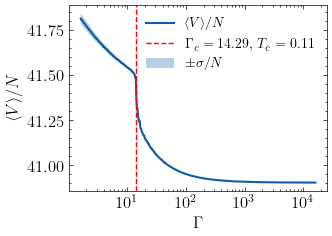

,temperature,avg_energy,std_energy,counts
0,1.000000,9032.001685,6.571415,1633
1,0.980000,9030.206592,6.209658,1633
2,0.960400,9030.265091,6.375322,1633
3,0.941192,9029.765020,6.148300,1633
4,0.922368,9028.266706,6.360256,1633
...,...,...,...,...
452,0.000108,8835.358707,0.002252,1633
453,0.000106,8835.355867,0.002489,1633
454,0.000104,8835.355296,0.002586,1633
455,0.000102,8835.354548,0.002503,1633


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def gamma(rho, T):
    # Standard OCP definition: Gamma = (Q^2 / a) / (kB * T)
    # where a is the ion-sphere radius: (3 / (4 * pi * rho))^(1/3)
    # Using k_B = 1 and Q = 1 for simplicity, adjust as needed.
    a = (3.0 / (4.0 * np.pi * rho))**(1.0/3.0)
    return 1.0 / (a * T)

def get_detailed_energy_stats(simulation_path, df_results, parameters, discard_fraction=0.3):
    energy_evolution_file = simulation_path / "energy.out"
    N = parameters['N']
    rho = parameters['density']
    
    # Load the data
    df = pd.read_csv(energy_evolution_file, sep='\s+', header=None, 
                     names=['mc_step', 'energy', 'temperature'])
    
    results = []
    # Loop through each temperature in the annealing schedule
    for temp, group in df.groupby('temperature', sort=False):
        # Discard equilibration phase
        n_steps = len(group)
        data = group.iloc[int(n_steps * discard_fraction):]
        
        avg_e = data['energy'].mean()
        std_e = data['energy'].std()
        
        results.append({
            'temperature': temp,
            'avg_energy': avg_e,
            'std_energy': std_e,
            'counts': len(data)
        })

    stats_df = pd.DataFrame(results)

    plt.figure()
    T = stats_df['temperature']
    g = gamma(rho, T)
    E = stats_df['avg_energy'] / N 
    err = stats_df['std_energy'] / N
    
    g_c = df_results['gamma'].values[0]
    T_c = df_results['Tc'].values[0]
    
    plt.plot(g, E, '-', linewidth=1.5, label=r'$\langle V \rangle / N$')
    plt.axvline(g_c, linestyle='--', linewidth=1, color='red', 
                label=rf"$\Gamma_c ={g_c:.2f}$, $T_c = {T_c:.2f}$")
    plt.fill_between(g, E - err, E + err, alpha=0.3, label=r'$\pm \sigma / N$')

    plt.xlabel(r'$\Gamma$')
    plt.ylabel(r'$\langle V \rangle/N$')
    plt.xscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig(simulation_path / "energy_per_particle_vs_gamma_n1.0_N216.pdf")
    plt.show()

    return stats_df

get_detailed_energy_stats(simulation_path, df_results, parameters, discard_fraction=0.3)

Results saved in: output/n216_density1.00_t1.0-0.0001-0.98/gr_peaks_results.csv


<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_63322/1519985517.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(gdr_file, sep='\s+', header=None, names=['r', 'gr',])


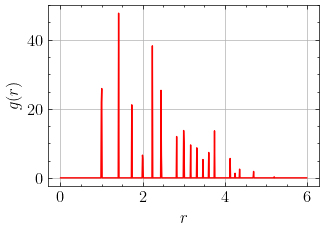

,r,Acc. Neigh
0,1.005,6
1,1.415,18
2,1.735,26
3,1.995,32
4,2.235,56
5,2.445,80
6,2.825,92
7,2.995,119
8,3.165,131
9,3.315,143


In [36]:
def get_gdr(simulation_path, parameters):
    gdr_file = simulation_path / "rdf.out"
    df = pd.read_csv(gdr_file, sep='\s+', header=None, names=['r', 'gr',])
    rho = parameters['density']
    r = df['r'].to_numpy()
    gr = df['gr'].to_numpy()
    dr = r[1]-r[0]
    N = parameters["N"]
    density = parameters["density"]
    a = density**(-1/3)
    
    dNc = 4 * np.pi * (r**2) * rho * gr * dr
    Nc = np.cumsum(dNc)

    peak_idx, _ = find_peaks(gr, height=5.0)

    results = []
    for i, idx in enumerate(peak_idx):
        distance_r = r[idx]
        idx_end_peak = min(idx + 2, len(r) - 1) 
        acc_neigh = Nc[idx_end_peak]
        results.append({
            'r' : distance_r,
            'Acc. Neigh' : round(acc_neigh)
        })

    df_results = pd.DataFrame(results)
    output_csv = simulation_path / "gr_peaks_results.csv"

    if not os.path.isfile(output_csv):
        df_results.to_csv(output_csv, index=False)
    else:
        df_results.to_csv(output_csv, mode='a', header=False, index=False)

    print(f"Results saved in: {output_csv}")

    # Plot 
    plt.figure()
    plt.plot(df['r'], df['gr'], color = 'red', label='Energía del sistema')
    plt.xlabel(r'$r$')
    plt.ylabel(r'$g(r)$')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(simulation_path / "gdr.pdf")
    plt.show()

    return df_results

df_results = get_gdr(simulation_path, parameters)
df_results

In [37]:
# def get_structure_factor(simulation_path, parameters):
#     sq = simulation_path / "sq.out"
#     df = pd.read_csv(sq, sep='\s+', header=None, names=['q', 'sq',])

#     # Plot 
#     plt.figure()
#     plt.plot(df['q'], df['sq'], color = 'green', label='Energía del sistema')
#     plt.xlabel(r'$r$')
#     plt.ylabel(r'$g(r)$')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig(simulation_path / "sq.pdf")
#     plt.show()

#     return df

# get_structure_factor(simulation_path, parameters)


In [38]:
def get_positions_plot(filename, saved_filename):

    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_atoms = int(lines[0])
    block_size = num_atoms + 2
    total_frames = len(lines) // block_size
    
    all_data = []
    for f in range(total_frames):
        start = f * block_size + 2
        end = start + num_atoms
        frame_coords = [l.split()[1:4] for l in lines[start:end]]
        
        df_frame = pd.DataFrame(frame_coords, columns=['x', 'y', 'z'], dtype=float)
        df_frame['frame'] = f  
        all_data.append(df_frame)

    df = pd.concat(all_data, ignore_index=True)

    last_frame = df[df['frame'] == df['frame'].max()]

    fig = px.scatter_3d(
        last_frame,
        x='x', y='y', z='z',
        opacity=1.0,
        template="plotly_white"
    )

    fig.update_traces(
        marker=dict(
            size=7,
            color='red',
            line=dict(width=0.5, color='black')
        )
    )

    # Box edges 
    xmin, ymin, zmin = last_frame[['x','y','z']].min()
    xmax, ymax, zmax = last_frame[['x','y','z']].max()

    edges = [
        ([xmin,xmax],[ymin,ymin],[zmin,zmin]),
        ([xmin,xmax],[ymax,ymax],[zmin,zmin]),
        ([xmin,xmax],[ymin,ymin],[zmax,zmax]),
        ([xmin,xmax],[ymax,ymax],[zmax,zmax]),

        ([xmin,xmin],[ymin,ymax],[zmin,zmin]),
        ([xmax,xmax],[ymin,ymax],[zmin,zmin]),
        ([xmin,xmin],[ymin,ymax],[zmax,zmax]),
        ([xmax,xmax],[ymin,ymax],[zmax,zmax]),

        ([xmin,xmin],[ymin,ymin],[zmin,zmax]),
        ([xmax,xmax],[ymin,ymin],[zmin,zmax]),
        ([xmin,xmin],[ymax,ymax],[zmin,zmax]),
        ([xmax,xmax],[ymax,ymax],[zmin,zmax])
    ]

    for ex, ey, ez in edges:
        fig.add_scatter3d(x=ex, y=ey, z=ez, mode='lines',
                        line=dict(color='black', width=4),
                        showlegend=False)

    fig.update_layout(
        scene=dict(
            aspectmode='cube',
            xaxis=dict(showbackground=False, title='x'),
            yaxis=dict(showbackground=False, title='y'),
            zaxis=dict(showbackground=False, title='z'),
            camera=dict(
                projection=dict(type="orthographic"),
                eye=dict(x=1.6, y=1.6, z=1.3)
            )
        ),
        title_x=0.5
    )

    # Positions array
    pos = last_frame[['x','y','z']].values

    # Bonds
    tree = cKDTree(pos)
    dists, _ = tree.query(pos, k=7)  
    a = np.median(dists[:,1])        
    pairs = tree.query_pairs(r=1.2*a)

    for i, j in pairs:
        fig.add_scatter3d(
            x=[pos[i,0], pos[j,0]],
            y=[pos[i,1], pos[j,1]],
            z=[pos[i,2], pos[j,2]],
            mode='lines',
            line=dict(color='black', width=1),
            opacity=0.5,
            showlegend=False
        )
    # Face coloring
    # vertices = np.array([
    #     [xmin, ymin, zmin],  # 0
    #     [xmax, ymin, zmin],  # 1
    #     [xmax, ymax, zmin],  # 2
    #     [xmin, ymax, zmin],  # 3
    #     [xmin, ymin, zmax],  # 4
    #     [xmax, ymin, zmax],  # 5
    #     [xmax, ymax, zmax],  # 6
    #     [xmin, ymax, zmax],  # 7
    # ])

    # x, y, z = vertices.T

    # # Define the triangles using vertex indices
    # # (i, j, k) correspond to the 3 vertices of each triangle
    
    # # These lists define the 12 triangles (2 per face * 6 faces)
    # # The order must follow the vertices definition above
    # i_indices = [0, 0,  4, 4,  0, 0,  3, 3,  0, 0,  1, 1]
    # j_indices = [1, 2,  5, 6,  1, 5,  2, 6,  3, 7,  2, 6]
    # k_indices = [2, 3,  6, 7,  5, 4,  6, 7,  7, 4,  6, 5]

    # fig.add_trace(go.Mesh3d(
    #     x=x, 
    #     y=y, 
    #     z=z,
    #     # i, j, k are vectors of indices pointing to coordinates in x, y, z
    #     i=i_indices,
    #     j=j_indices,
    #     k=k_indices,
    #     color='lightgray',
    #     opacity=0.4,  # Lower opacity is usually better for bounding boxes
    #     flatshading=True,
    #     showscale=True,
    #     hoverinfo='skip' # Prevents hover labels on the box itself
    # ))
    # x_corners = [xmin, xmax, xmax, xmin, xmin, xmax, xmax, xmin]
    # y_corners = [ymin, ymin, ymax, ymax, ymin, ymin, ymax, ymax]
    # z_corners = [zmin, zmin, zmin, zmin, zmax, zmax, zmax, zmax]

    # fig.add_trace(go.Mesh3d(
    #     x=x_corners,
    #     y=y_corners,
    #     z=z_corners,
    #     # i, j, k are the indices of the vertices for each triangle
    #     i = [0, 0,  4, 4,  0, 0,  3, 3,  0, 0,  1, 1],
    #     j = [1, 2,  5, 6,  1, 5,  2, 6,  3, 7,  2, 6],
    #     k = [2, 3,  6, 7,  5, 4,  6, 7,  7, 4,  6, 5],
    #     color='gray',
    #     opacity=0.15,      # Lower opacity improves the "superposition" depth effect
    #     flatshading=True,  # Makes faces look flat rather than smoothed
    #     showscale=False,
    #     hoverinfo='skip',  # Disables hovering on the box so you can click atoms easily
    #     lightposition=dict(x=100, y=100, z=1000) # Ensures all faces are well-lit
    # ))

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            aspectmode='cube',
            xaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
            yaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
            zaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
            camera=dict(
                projection=dict(type="orthographic"),
                eye=dict(x=1.6, y=1.6, z=1.3)
            ),
            
        )
    )

    fig.show()
    fig.write_html(f"{saved_filename}.html")
    fig.write_image(f"{saved_filename}.pdf", scale=2, width=600, height=600)

    return 

filename = simulation_path / "final_position.xyz"
saved_filename = simulation_path / "positions"
get_positions_plot(filename, saved_filename)

KeyboardInterrupt: 

Resorting to unclean kill browser.


In [ ]:
parameters

{'melting': 1,
 'path': 'output_n216/n216_density1.00_t1.0-0.0001-0.98/final_position.xyz',
 'N': 216,
 'freeze_mc_steps': 0.5,
 'alpha': 0.8,
 'C0': 0.5,
 'density': 1.0,
 'charge': 1.0,
 'initial_temp': 0.0001,
 'final_temp': 10.0,
 'temp_step': 0.1,
 'L': 5.999999999999999}

In [ ]:
# import numpy as np
# import pandas as pd
# import plotly.express as px
# from scipy.spatial import cKDTree

# def get_positions_plot(filename, saved_filename):

#     with open(filename, 'r') as f:
#         lines = f.readlines()
    
#     num_atoms = int(lines[0])
#     block_size = num_atoms + 2
#     total_frames = len(lines) // block_size
    
#     all_data = []
#     for f in range(total_frames):
#         start = f * block_size + 2
#         end = start + num_atoms
#         frame_coords = [l.split()[1:4] for l in lines[start:end]]
#         df_frame = pd.DataFrame(frame_coords, columns=['x', 'y', 'z'], dtype=float)
#         df_frame['frame'] = f  
#         all_data.append(df_frame)

#     df = pd.concat(all_data, ignore_index=True)
#     last_frame = df[df['frame'] == df['frame'].max()]

#     fig = px.scatter_3d(
#         last_frame,
#         x='x', y='y', z='z',
#         opacity=1.0,
#         template="plotly_white"
#     )

#     fig.update_traces(
#         marker=dict(
#             size=7,
#             color='red',
#             line=dict(width=0.5, color='black')
#         )
#     )

#     # Box boundaries
#     xmin, ymin, zmin = last_frame[['x','y','z']].min()
#     xmax, ymax, zmax = last_frame[['x','y','z']].max()

#     # Define faces of the cube
#     faces = [
#         # Bottom face
#         (np.array([xmin, xmax, xmax, xmin]), np.array([ymin, ymin, ymax, ymax]), np.array([zmin]*4), 0.2),
#         # Top face
#         (np.array([xmin, xmax, xmax, xmin]), np.array([ymin, ymin, ymax, ymax]), np.array([zmax]*4), 0.4),
#         # Front face
#         (np.array([xmin, xmax, xmax, xmin]), np.array([ymin]*4), np.array([zmin, zmin, zmax, zmax]), 0.25),
#         # Back face
#         (np.array([xmin, xmax, xmax, xmin]), np.array([ymax]*4), np.array([zmin, zmin, zmax, zmax]), 0.35),
#         # Left face
#         (np.array([xmin]*4), np.array([ymin, ymin, ymax, ymax]), np.array([zmin, zmax, zmax, zmin]), 0.3),
#         # Right face
#         (np.array([xmax]*4), np.array([ymin, ymin, ymax, ymax]), np.array([zmin, zmax, zmax, zmin]), 0.45)
#     ]

#     for x, y, z, opacity in faces:
#         fig.add_traces(px.scatter_3d(
#             x=x, y=y, z=z
#         ).update_traces(marker=dict(size=0), showlegend=False).data)
#         # Use Mesh3d for the face
#         fig.add_mesh3d(
#             x=x,
#             y=y,
#             z=z,
#             color='gray',
#             opacity=opacity,
#             flatshading=True,
#             showscale=False
#         )

#     # Bonds
#     pos = last_frame[['x','y','z']].values
#     tree = cKDTree(pos)
#     dists, _ = tree.query(pos, k=7)  
#     a = np.median(dists[:,1])        
#     pairs = tree.query_pairs(r=1.2*a)

#     for i, j in pairs:
#         fig.add_scatter3d(
#             x=[pos[i,0], pos[j,0]],
#             y=[pos[i,1], pos[j,1]],
#             z=[pos[i,2], pos[j,2]],
#             mode='lines',
#             line=dict(color='black', width=1),
#             opacity=0.5,
#             showlegend=False
#         )

#     fig.update_layout(
#         margin=dict(l=0, r=0, b=0, t=0),
#         scene=dict(
#             aspectmode='cube',
#             xaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
#             yaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
#             zaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
#             camera=dict(
#                 projection=dict(type="orthographic"),
#                 eye=dict(x=1.6, y=1.6, z=1.3)
#             ),
#         )
#     )

#     fig.show()
#     fig.write_html(f"{saved_filename}.html")
#     fig.write_image(f"{saved_filename}.pdf", scale=2, width=600, height=600)


# filename = simulation_path / "final_position.xyz"
# saved_filename = simulation_path / "positions"
# get_positions_plot(filename, saved_filename)

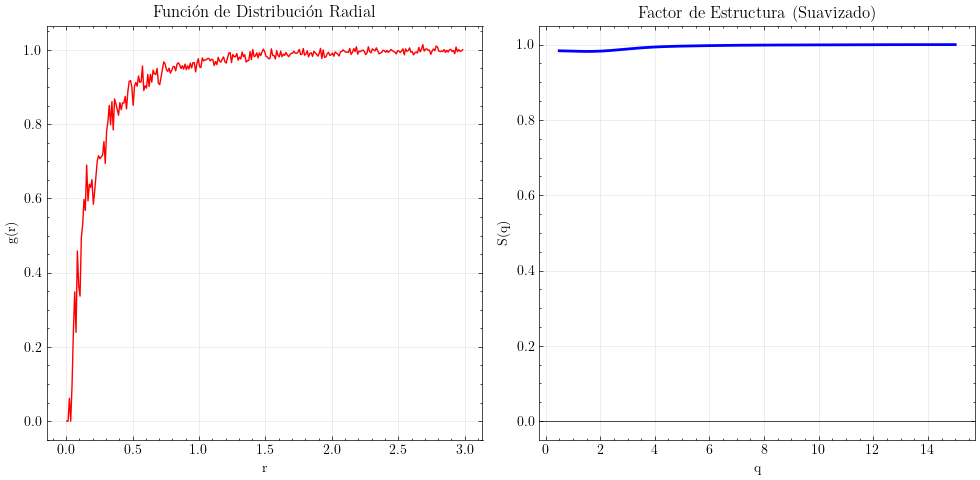

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def calculate_sq_smooth(rdf_file, density, L):
    # Cargar g(r)
    # Asumimos que rdf.out tiene dos columnas: r, g(r)
    data = np.loadtxt(rdf_file)
    r = data[:, 0]
    gr = data[:, 1]
    
    # Parámetros
    dr = r[1] - r[0]
    q = np.linspace(0.5, 15.0, 300) # Rango de q habitual
    sq = np.zeros_like(q)
    
    # Aplicamos una ventana de Lorch para suavizar el corte en L/2
    # Esto elimina las oscilaciones negativas falsas (Gibbs phenomenon)
    cutoff_index = np.searchsorted(r, L/2.0)
    r_cut = r[:cutoff_index]
    gr_cut = gr[:cutoff_index]
    
    # Factor de ventana (Lorch window)
    window = np.sinc(r_cut * np.pi / (L/2.0)) # sinc(x) = sin(pi*x)/(pi*x) en numpy
    
    for i, qi in enumerate(q):
        # Integral transformada: 1 + 4*pi*rho * Int( r^2 * (g(r)-1) * sin(qr)/qr )
        integrand = r_cut**2 * (gr_cut - 1.0) * (np.sin(qi * r_cut) / (qi * r_cut)) * window
        integral = np.trapezoid(integrand, r_cut)
        sq[i] = 1.0 + 4.0 * np.pi * density * integral
        
    return q, sq

# --- USO ---
# Asegúrate de poner la densidad correcta de tu simulación
rho = 0.1 
L_box = (64 / rho)**(1/3) # Recalcula L según tu N y rho
gdr_file = simulation_path / "rdf.out"
q, sq = calculate_sq_smooth(gdr_file, rho, L_box)

# Graficar
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
data = np.loadtxt(gdr_file) # Cargar para pintar g(r) también
plt.plot(data[:,0], data[:,1], 'r-', label='g(r) Simulación')
plt.xlabel('r')
plt.ylabel('g(r)')
plt.title('Función de Distribución Radial')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(q, sq, 'b-', lw=2, label='S(q) Calculado')
plt.xlabel('q')
plt.ylabel('S(q)')
plt.title('Factor de Estructura (Suavizado)')
plt.axhline(0, color='k', lw=0.5) # Línea base
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

# Intentamos importar el módulo compilado
try:
    import sq_fortran
except ImportError:
    print("Error: No se encuentra el módulo 'sq_fortran'. Asegúrate de haber compilado el archivo .f90.")
    sys.exit(1)

def calcular_sq_xyz_fortran(path_archivo, L=6.0, n_max=10):
    print(f"Procesando {path_archivo} usando motor Fortran...")
    
    # 1. Parámetros del espacio recíproco (Igual que antes)
    n_range = np.arange(-n_max, n_max + 1)
    nx, ny, nz = np.meshgrid(n_range, n_range, n_range)
    n_vecs = np.vstack([nx.ravel(), ny.ravel(), nz.ravel()]).T
    n_vecs = n_vecs[np.any(n_vecs != 0, axis=1)]
    
    q_vecs = (2.0 * np.pi / L) * n_vecs
    q_mags = np.linalg.norm(q_vecs, axis=1)
    
    # Preparamos los componentes Q para pasarlos a Fortran por separado (más eficiente)
    # Es importante usar 'ascontiguousarray' para asegurar compatibilidad con Fortran
    qx = np.ascontiguousarray(q_vecs[:, 0], dtype=np.float64)
    qy = np.ascontiguousarray(q_vecs[:, 1], dtype=np.float64)
    qz = np.ascontiguousarray(q_vecs[:, 2], dtype=np.float64)
    
    # Indices para el promedio isotrópico
    q_unicos, indices, counts = np.unique(np.round(q_mags, 4), return_inverse=True, return_counts=True)
    s_q_final_iso = np.zeros_like(q_unicos, dtype=float)
    
    num_frames = 0
    start_time = time.time()

    # 2. Lectura y Cálculo
    with open(path_archivo, 'r') as f:
        while True:
            linea_n = f.readline()
            if not linea_n: break
            
            try:
                N = int(linea_n.strip())
                f.readline() # Saltar comentario
                
                # Leemos coordenadas como texto y convertimos
                # (Leer bloques grandes es más rápido, pero mantenemos tu lógica por simplicidad)
                coords_raw = [f.readline().split() for _ in range(N)]
                
                # Extraer X, Y, Z. Ignoramos el símbolo químico (columna 0)
                # Convertimos a arrays contiguos de float64 para Fortran
                coords = np.array(coords_raw)[:, 1:4].astype(np.float64)
                x = np.ascontiguousarray(coords[:, 0])
                y = np.ascontiguousarray(coords[:, 1])
                z = np.ascontiguousarray(coords[:, 2])
                
                # --- LLAMADA A FORTRAN ---
                # Fortran calcula S(q) para todos los vectores Q en este frame
                # No necesitamos bucles en Python ni matrices complejas gigantes
                s_q_raw = sq_fortran.sq_module.calculate_frame_sq(x, y, z, qx, qy, qz, N, len(qx))
                
                # --- Promediado Isotrópico (Rápido en NumPy) ---
                # Sumamos los resultados crudos a sus bins correspondientes
                s_q_iso_frame = np.zeros_like(q_unicos)
                np.add.at(s_q_iso_frame, indices, s_q_raw)
                s_q_iso_frame /= counts
                
                # Acumular al total
                s_q_final_iso += s_q_iso_frame
                num_frames += 1
                
                if num_frames % 100 == 0:
                    elapsed = time.time() - start_time
                    print(f"Frames: {num_frames} | Tiempo: {elapsed:.2f}s | FPS: {num_frames/elapsed:.1f}")

                if num_frames >= 5000:
                    break
                    
            except ValueError as e:
                print(f"Error leyendo frame: {e}")
                break

    return q_unicos, s_q_final_iso / num_frames

# --- Ejecución ---
q, sq = calcular_sq_xyz_fortran(simulation_path / 'positions_t0.xyz', L=6.0)

NameError: name 'simulation_path' is not defined

In [ ]:
parameters['L']

5.999999999999999

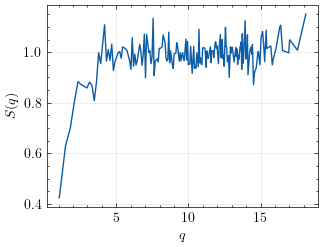

In [ ]:
plt.figure()
plt.plot(q, sq, '-', markersize=2, label='Datos S(q)')
plt.xlabel('$q$')
plt.ylabel('$S(q)$')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
df = pd.DataFrame({'q': q, 'S(q)': sq})
df.to_csv(simulation_path / "sq_calculado.csv", index=False)
df[df['S(q)'] > 1]

,q,S(q)
13,4.1888,1.108096
15,4.4429,1.009907
17,4.6832,1.031910
21,5.2360,1.002478
23,5.4414,1.020928
...,...,...
172,16.3912,1.106817
173,16.5245,1.006626
175,17.0149,1.048925
176,17.5542,1.007950


In [ ]:
from scipy.signal import find_peaks

def analizar_estructura_cristalina(q, sq, prominence=10.0):
    # 1. Encontrar picos (usamos 'prominence' para ignorar el ruido pequeño)
    # Ajusta 'prominence' según el alto de tus picos (en tu gráfica > 1.0 está bien)
    peaks, _ = find_peaks(sq, prominence=prominence)
    
    q_peaks = q[peaks]
    s_peaks = sq[peaks]
    
    # Ordenar por posición de q (por si acaso)
    sorted_indices = np.argsort(q_peaks)
    q_peaks = q_peaks[sorted_indices]
    
    if len(q_peaks) < 2:
        print("No se encontraron suficientes picos para el análisis.")
        return

    q1 = q_peaks[0]
    ratios = q_peaks / q1
    
    print("-" * 40)
    print(f"{'Pico':<8} | {'q':<10} | {'S(q)':<10} | {'Ratio q/q1':<12}")
    print("-" * 40)
    for i, (qp, sp, r) in enumerate(zip(q_peaks[:6], s_peaks[:6], ratios[:6])):
        print(f"{i+1:<8} | {qp:<10.3f} | {sp:<10.2f} | {r:<12.3f}")
    
    # 2. Comparación con estructuras ideales
    print("\nComparación con estructuras ideales (ratios q/q1):")
    estructuras = {
        "Cúbica Simple (SC)": [1.0, 1.414, 1.732], # sqrt(1, 2, 3, 4, 5)
        "Centrada Cuerpo (BCC)": [1.0, 1.414, 1.732], # sqrt(2, 4, 6, 8, 12) / sqrt(2)
        "Centrada Caras (FCC)": [1.0, 1.155, 1.633], # sqrt(3, 4, 8, 11, 12) / sqrt(3)
    }
    
    for nombre, valores in estructuras.items():
        error = np.mean(np.abs(np.array(ratios[:len(valores)]) - np.array(valores)))
        print(f"- {nombre}: error promedio {error:.4f}")

# --- Uso ---
# q, sq = calcular_sq_xyz(...)
analizar_estructura_cristalina(q, sq, prominence=1.0)

No se encontraron suficientes picos para el análisis.


In [ ]:
import numpy as np
from scipy.signal import find_peaks

def calcular_parametro_red(q, sq, L, N):
    # 1. Encontrar el primer pico real (ignorando el ruido cerca de q=0)
    # Filtramos para buscar picos a partir de q=1.0 para evitar el ruido de la caja
    mask = q > 1.0
    indices_picos, _ = find_peaks(sq[mask], prominence=20.0)
    print(indices_picos)
    
    if len(indices_picos) == 0:
        print("No se detectaron picos claros.")
        return

    # q1 es la posición del primer pico encontrado
    q1 = q[mask][indices_picos[0]]
    
    print(f"--- Análisis del Parámetro de Red (a) ---")
    print(f"Primer pico detectado en q1 = {q1:.4f}\n")

    # 2. Relaciones teóricas para q1: q1 = (2*pi / a) * sqrt(s)
    # SC: s=1 (100), BCC: s=2 (110), FCC: s=3 (111)
    estructuras = {
        "Cúbica Simple (SC)": {"s": 1, "n_at": 1},
        "Centrada Cuerpo (BCC)": {"s": 2, "n_at": 2},
        "Centrada Caras (FCC)": {"s": 3, "n_at": 4}
    }

    print(f"{'Estructura':<22} | {'a (de la gráfica)':<18} | {'a (de la densidad)':<18}")
    print("-" * 65)

    for nombre, info in estructuras.items():
        # a calculado desde la posición del pico en el gráfico
        a_grafica = (2.0 * np.pi / q1) * np.sqrt(info['s'])
        
        # a calculado desde la densidad (N y L)
        # Vol_celda = a^3, Densidad = N/L^3 = n_at/a^3  =>  a = (n_at * L^3 / N)^(1/3)
        a_densidad = np.power((info['n_at'] * (L**3)) / N, 1/3)
        
        error = abs(a_grafica - a_densidad) / a_densidad * 100
        print(f"{nombre:<22} | {a_grafica:<18.4f} | {a_densidad:<18.4f} (Error: {error:.1f}%)")

# --- Para ejecutarlo al final de tu código ---
calcular_parametro_red(q, sq, L=parameters['L'], N=256) # N lo obtienes de la lectura del .xyz

[]
No se detectaron picos claros.


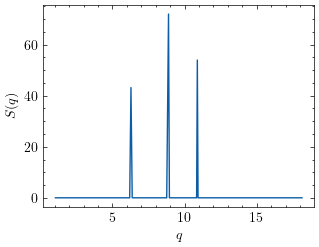

In [ ]:
N_MAX = 10
MAX_FRAMES = 5_000

def structure_factor(file_xyz, L):
    n_range = np.arange(-N_MAX, N_MAX + 1)
    nx, ny, nz = np.meshgrid(n_range, n_range, n_range)
    n_vecs = np.vstack([nx.ravel(), ny.ravel(), nz.ravel()]).T
    n_vecs = n_vecs[np.any(n_vecs != 0, axis=1)] # Delete (0,0,0)
    
    q_vecs = (2.0 * np.pi / L) * n_vecs
    q_mags = np.linalg.norm(q_vecs, axis=1)
    
    # Fortran array preparation
    qx = np.ascontiguousarray(q_vecs[:, 0], dtype=np.float64)
    qy = np.ascontiguousarray(q_vecs[:, 1], dtype=np.float64)
    qz = np.ascontiguousarray(q_vecs[:, 2], dtype=np.float64)
    
    q, indices, counts = np.unique(np.round(q_mags, 4), return_inverse=True, return_counts=True)
    sq = np.zeros_like(q)
    
    num_frames = 0

    with open(file_xyz, 'r') as f:
        while num_frames < 5_000:
            line = f.readline()
            if not line: break
            try:
                N_atoms = int(line.strip())
                f.readline() 
                
                coords_raw = [f.readline().split() for _ in range(N_atoms)]
                coords = np.array(coords_raw)[:, 1:4].astype(np.float64)
                
                x = np.ascontiguousarray(coords[:, 0])
                y = np.ascontiguousarray(coords[:, 1])
                z = np.ascontiguousarray(coords[:, 2])

                sq_frame = sq_fast.sq_calc.compute_sq_kernel(x, y, z, qx, qy, qz)
                
                # Accumulate isotropic S(q)
                s_q_iso_frame = np.zeros_like(q)
                np.add.at(s_q_iso_frame, indices, sq_frame)
                sq += (s_q_iso_frame / counts)
                
                num_frames += 1

            except ValueError:
                break
    
    sq /= num_frames
    plt.figure()
    plt.plot(q, sq)
    plt.xlabel('$q$')
    plt.ylabel('$S(q)$')
    plt.show()

    df = pd.DataFrame({'q': q, 'S(q)': sq})
    df.to_csv(simulation_path / "sq.csv", index=False)

    return q, sq

file_xyz = simulation_path / "positions_t0.xyz"
L = parameters['L']

q, sq = structure_factor(file_xyz=file_xyz, L=L)